# Pluri-Gaussian simulation

In this notebook we demonstrate an application of pluri-Gaussian simulation (PGS).

In this example, we consider one indicator variable $Z(\mathbf{x})$ (in the code `Z`) that is related to two *latent* Gaussian field $T_1(\mathbf{x})$ (in the code `T1`) and $T_2(\mathbf{x})$ (in the code `T2`). Once $T_1$ and $T_2$ are simulated, an indicator variable is assigned to $Z$ thorough the $f$ function

$$Z=f(Z_1, Z_2)$$

The function $f$ is defined via a "flag", that will be described later.

First, import the required modules

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
# import package 'geone'
import geone as gn

Define number of categories, the corresponding codes and the colors (to be user later for plotting)

In [2]:
ncat = 4
categVal = np.array([1, 2, 3, 4])

categCol = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c']
im_T1_display={'cmap':'magma'}
im_T2_display={'cmap':'inferno'}
im_Z_display={'categ':True, 'categVal':categVal, 'categCol':categCol}

Define the simulation grid (the simulation *domain*)

In [3]:
nx, ny, nz = 220, 210, 1    # number of cells
sx, sy, sz = 0.5, 0.5, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

## Covariance models for the latent fields

Then, define the two variogram models to be used to simulate the two latent Gaussian fields $T_1$ and $T_2$. Two "Matern" variogram models are used. One isotropic, with radius $25$, the other anysotropic, with radius $(30,10)$ and main direction $-45\degree$.

>**Detail** The function ``cov_matern_get_r_param`` is used to compute the `scale` parameter (``r``) from a Matern variogram with a given ``nu`` and an effective range provided as input.

In [4]:
# Covariance model for the latent field T1
r_T1 = 1.0*np.array([25.0, 25.0])
w_T1 = 1.0
nu_T1 = 1.5
cov_model_T1 = gn.covModel.CovModel2D(elem=[
    ('matern', {'w':w_T1, 'r':np.array([gn.covModel.cov_matern_get_r_param(nu_T1, r) for r in r_T1]), 'nu':nu_T1}),
    ], alpha=0.0, name='cov_model_T1')

/home/alex/.virtualenvs/gmg/lib/python3.10/site-packages/geone/covModel.py:209: RuntimeWarning: invalid value encountered in scalar power
  u1 = (0.5*u)**nu


In [5]:
# Covariance model for the latent field T2
r_T2 = 1.0*np.array([30.0, 10.0])
w_T2 = 1.0
nu_T2 = 1.5
cov_model_T2 = gn.covModel.CovModel2D(elem=[
    ('matern', {'w':w_T2, 'r':np.array([gn.covModel.cov_matern_get_r_param(nu_T2, r) for r in r_T2]), 'nu':nu_T2}),
    ], alpha=-45.0, name='cov_model_T2')

One should also provide the mean values of the latent Gaussian fields. Setting them to `0` is OK.

In [6]:
# Mean of T1, T2
mean_T1 = 0.0
mean_T2 = 0.0

## Flag definition and plot

One important step in PGS is the definition of the "flag" function, that is the function $f$ that allows to transition from the two (or more) latent fields $T_1$ and $T_2$ to the indicator variable $Z$.


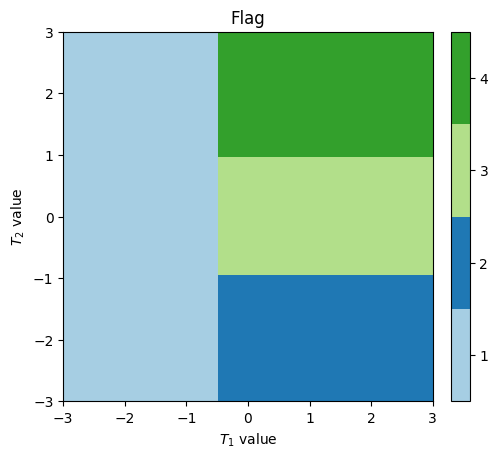

In [7]:
# Definition of the "flag" function
def flag_value(x, y):
    v0, v1, v2, v3 = categVal
    x1 = x < -0.5
    y1 = y < -1.
    y2 = y < 1.
    return v0 * x1 + (1-x1) * (v1 * y1 + (1-y1) * (v2*y2 + v3*(1-y2)))

# We use the function `drawImage2D` of `geone`. Therefore, one should create a "fake" Image object to plot
# the flag function.
T1_min = -3
T1_max = 3
T2_min = -3
T2_max = 3
fnx, fny, fnz = 50, 50, 1
fox, foy, foz = T1_min, T2_min, 0.0
fsx, fsy, fsz = (T1_max - fox)/fnx, (T2_max - foy)/fny, 1.0
fx = fox + (np.arange(fnx)+0.5)*fsx 
fy = foy + (np.arange(fny)+0.5)*fsy 
yy, xx = np.meshgrid (fy, fx, indexing='ij')
fv = flag_value(xx, yy)
im_flag = gn.img.Img(nx=fnx, ny=fny, nz=fnz, sx=fsx, sy=fsy, sz=fsz, ox=fox, oy=foy, oz=foz, nv=1, val=fv)

# Plot
gn.imgplot.drawImage2D(im_flag, **im_Z_display)
plt.xlabel('$T_1$ value')
plt.ylabel('$T_2$ value')
plt.title(f'Flag')
plt.show()

This "flag" illustrate quite easily the constraints and the possibility of contact between facies. For example, facies `1` can be in contact with all the other facies, but facies `4` cannot be directly in contact with `2`, for example.

## Conditioning data

PGS can be also account for conditioning data. As usal, `x` are the (2D) coordinates and `v` are the values of the facies codes.

In [8]:
# Coordinates
x = np.array([[37.25, 25.25],
              [67.25, 24.25],
              [50.25, 52.25],
              [36.25, 80.25],
              [66.25, 81.25]])
# "Measurements"
v = np.array([1, 1, 2, 4, 4])
# Collect some colors for later plotting purposes
v_col = [categCol[np.where(vv ==categVal)[0][0]] for vv in v] 


## Pluri-Gaussian simulation

The PGS is perfomed by the function `pluriGaussianSim`.

The input arguments are the two covariance models of the latent Gaussian field (`cov_model_T1` and `cov_model_T2`), the function $f$ (`flag_value`), the definition of the structured grid, the conditioning data (`x` and `v`).

Some parameters are used to tune the algorithm that allows to honour the conditioning data (`accept_init`, `accept_pow`, `nh_iter_min`, `mh_iter_max`).

In [9]:
# Number of realizations and seed
nreal = 3
seed_sim = 1345
np.random.seed(seed_sim)

# Simulation
Z, T1, T2, n_cond_ok = gn.pgs.pluriGaussianSim(
    cov_model_T1, cov_model_T2, flag_value, (nx, ny), (sx, sy), (ox, oy),
    x=x, v=v,
    params_T1={'mean':mean_T1},
    params_T2={'mean':mean_T2, 'rangeFactorForExtensionMin':2},
    nreal=nreal,
    accept_init=0.75, accept_pow=2.0,
    mh_iter_min=100, mh_iter_max=200,
    full_output=True,
    verbose=4,
)

PLURIGAUSSIANSIM: simulation 1 of 3...
PLURIGAUSSIANSIM: simulation 2 of 3...
PLURIGAUSSIANSIM: simulation 3 of 3...


With the argument `full_output=True`, the function `pluriGaussianSim` returns the simulated indicator field $Z$, the two latent fields $T_1$ and $T_2$. The variable `n_cond_ok` is a list of 1D arrays; the list has the same lenght of the number of realizations. For each realization, the lenght of the array correponds to the number of Metropolis-Hasting iteration done. The array contains the number of data honoured at a given iteration step.

The output can be used to fill the values of some geone *Image* objects, so that it will be easy to plot them later.

In [10]:
# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)
im_T1 = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=T1.shape[0], val=T1)
im_T2 = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=T2.shape[0], val=T2)

## Check conditioning

It is also useful to check if all the conditioning are where honoured

In [11]:
# Check only if there are conditioning data and there is a simulation result
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], 0., sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value of the computed Z at the conditioning data locations
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(im_Z_value_at_x == v)
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        print('Conditioning data, ok at:', 100*np.mean(im_Z_value_at_x == v), '%')

Conditioning data honoured ? True


## Plot

Here we simply select one realization with the variable `ireal`, but you can choose another index ($<$`nreal`) to double check.

Note that here we plot again the flag by using the true max and min values attained by the latend function $T_1$ and $T_2$. In the previous plot of the flag function we only guessed them.

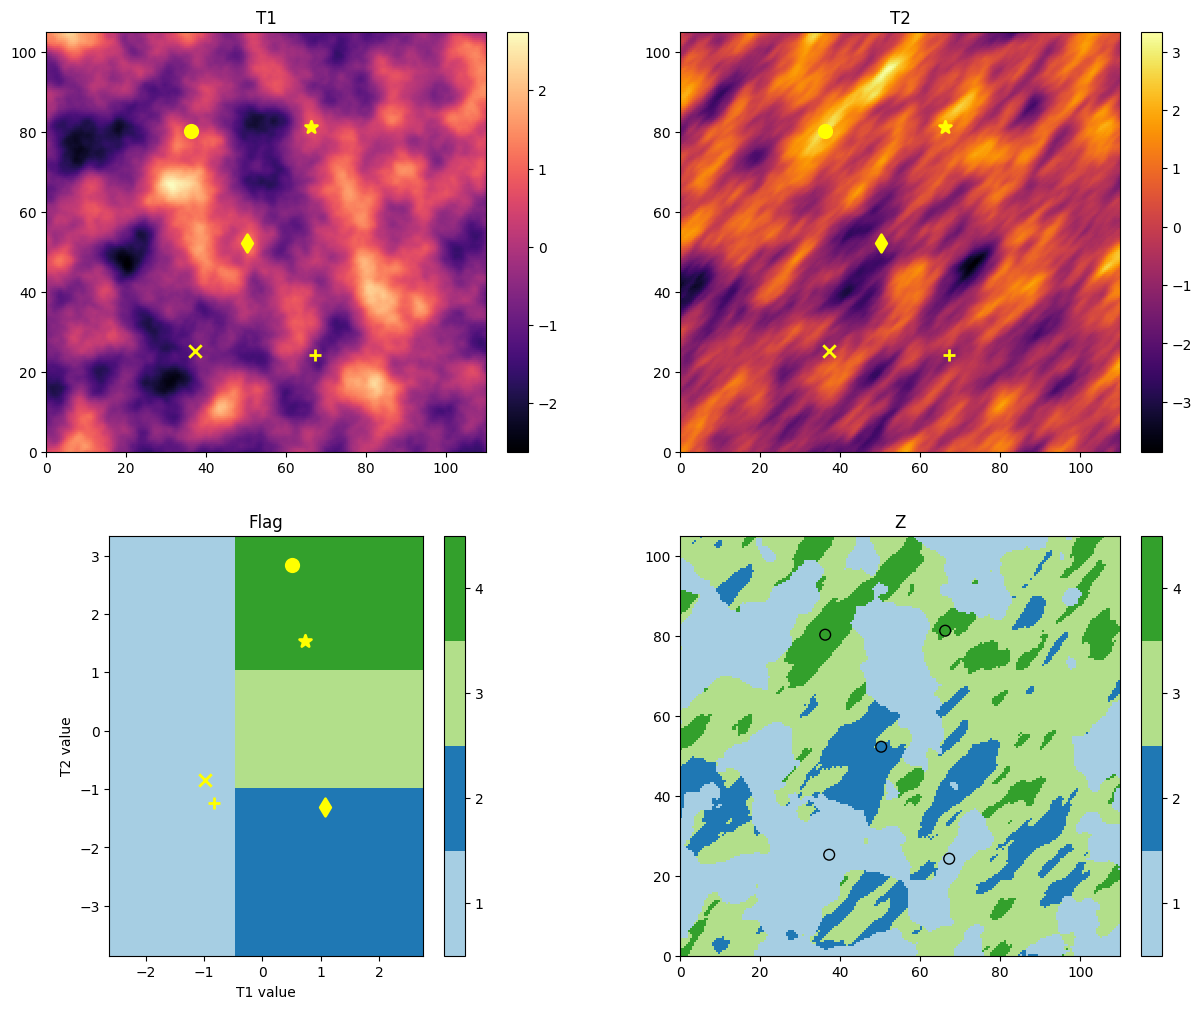

In [12]:
ireal = 0 # realization to plot

# Fill and Image with the (simulated) values attained by T_1 and T_2
fnx, fny, fnz = 50, 50, 1
fox, foy, foz = im_T1.val[ireal].min(), im_T2.val[ireal].min(), 0.0
fsx, fsy, fsz = (im_T1.val[ireal].max() - fox)/fnx, (im_T2.val[ireal].max() - foy)/fny, 1.0
fx = fox + (np.arange(fnx)+0.5)*fsx 
fy = foy + (np.arange(fny)+0.5)*fsy 
yy, xx = np.meshgrid (fy, fx, indexing='ij')
fv = flag_value(xx, yy)
im_flag = gn.img.Img(nx=fnx, ny=fny, nz=fnz, sx=fsx, sy=fsy, sz=fsz, ox=fox, oy=foy, oz=foz, nv=1, val=fv)

# Define some markers for the conditioning data
marker_loc = ['x', '+', 'd', 'o', '*']

# Plot
plt.subplots(2,2, figsize=(15, 12))

# T1
plt.subplot(2,2,1)
plt.title('T1')
gn.imgplot.drawImage2D(im_T1, iv=ireal, **im_T1_display)
# Add conditioning location
if x is not None:
    # plt.plot(x[:,0], x[:,1], 'rx', markersize=20)
    for i in range(len(x)): 
        plt.scatter(x[i,0], x[i,1], marker=marker_loc[i%len(marker_loc)], color='yellow', s=80, linewidths=2)

# T2
plt.subplot(2,2,2)
plt.title('T2')
gn.imgplot.drawImage2D(im_T2, iv=ireal, **im_T2_display)
# Add conditioning location
if x is not None:
    # plt.plot(x[:,0], x[:,1], 'rx', markersize=20)
    for i in range(len(x)): 
        plt.scatter(x[i,0], x[i,1], marker=marker_loc[i%len(marker_loc)], color='yellow', s=80, linewidths=2)

# Z
plt.subplot(2,2,4)
plt.title('Z')
gn.imgplot.drawImage2D(im_Z, iv=ireal, **im_Z_display)
# Add conditioning data
if x is not None:
    plt.scatter(x[:,0], x[:,1], marker='o', s=60, color=v_col, edgecolors='black', linewidths=1)

# flag
plt.subplot(2,2,3)
plt.title(f'Flag')
gn.imgplot.drawImage2D(im_flag, **im_Z_display)
plt.xlabel('T1 value')
plt.ylabel('T2 value')

# Add conditioning location
if x is not None:
    indx, indy, indz = gn.img.pointToGridIndex(x[:,0], x[:,1], np.zeros_like(x[:,0]), sx, sy, sz, ox, oy, oz)
    y1 = np.array([im_T1.val[ireal, iz, iy, ix] for ix, iy, iz in zip(indx, indy, indz)])
    y2 = np.array([im_T2.val[ireal, iz, iy, ix] for ix, iy, iz in zip(indx, indy, indz)])
    for i in range(len(y1)):
        plt.scatter(y1[i], y2[i], marker=marker_loc[i%len(marker_loc)], color='yellow', s=80, linewidths=2)


plt.show()